# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy.interpolate as si
import scipy.integrate as spi
import numba
import scipy.optimize as so
import scipy.linalg as la
import scipy.signal as sg
import scipy.constants as sc
import timeit

# Function Definitions

In [2]:
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

Trapezoid Rule for Numerical Integration

In [3]:
def trapezoid(f,a,b,N,e0): # Trapezoidal rule for numerical integration
    Δ = (b-a)/N    # Spacing between two consecutive points 
    X = np.linspace(a,b,N,endpoint=False) # Array of x values 
    return 0.5*Δ*(f(a,e0)+f(b,e0)) + Δ*np.sum([f(x,e0) for x in X[1:]]) 

Band Structure

The Bloch state basis is used to solve the eigenvalues and eigenstates of a periodic potential. We begin by solving the Time Independent Schrodinger Equation (TISE) in the Bloch state basis.  The Bloch states are the eigenstates of the Hamiltonian and the energy dispersion relation or band structure is formed by the respective eigenvalues. 
$$
\begin{equation}
    \hat{H_{0}}\hspace{2pt}\phi_{\mathbf{k}}^{(n)}(\mathbf{r}) = E^{(n)} \phi_{\mathbf{k}}^{(n)}(\mathbf{r})
%     \label{eq:1.1}\tag{2.1.1}
\end{equation}
$$
where $\phi_{\mathbf{k}}^{(n)}(\mathbf{r})$ is the nth Bloch state, $E^{n}$ is the corresponding energy eigenvalue and $\hat{H}_{0}$ is the Hamiltonian given by the equation below:
$$
\begin{equation}
    \hat{H_{0}} = \frac{|\mathbf{\hat{p}}|^{2}}{2m} + V(\mathbf{\hat{r}}) %\label{eq:1.2}\tag{2.1.2}
\end{equation}
$$
where $\mathbf{\hat{p}}$ is the momentum operator and V($\mathbf{\hat{r}}$) is the periodic potential.
According to the Bloch's theorem, the eigenstates of a periodic potential can be written as a product of plane wave and a periodic function u($\textbf{r}$):
$$
\begin{equation}
    \phi_{\mathbf{k}}^{(n)}(\mathbf{r}) = e^{i\mathbf{k}\cdot\mathbf{r}}u(\mathbf{r}) %\label{eq:1.3}\tag{2.1.3}
\end{equation}
$$

V($\textbf{r}$) and u($\textbf{r}$) are periodic with lattice vector $\textbf{R}$.
$$
\begin{gather}
   V(\mathbf{r}+\mathbf{R}) = V(\mathbf{r}) %\label{eq:1.4}\tag{2.1.4}\\
   u(\mathbf{r}+\mathbf{R}) = u(\mathbf{r}) %\label{eq:1.5}\tag{2.1.5}
\end{gather}
$$
Therefore, the Bloch state can written as a superposition as described below:
$$
\begin{equation}
\phi_{\mathbf{k}}^{(n)}(\mathbf{r}) = \sum_{\mathbf{G}}C_{\mathbf{G}}^{n}\hspace{2pt}e^{i{(\mathbf{k}+\mathbf{G})\cdot\mathbf{r}}} %\label{eq:1.6}\tag{2.1.6}
\end{equation}
$$
where $\textbf{k}$ has values in the first Brillouin zone %$\frac{-\pi}{a_{0}}\leq k_{0} \leq \frac{\pi}{a_{0}} $
and $\textbf{G}$ is the reciprocal wave vector.
Similarly, due to periodicity the potential can be expanded as a Fourier series,
$$
\begin{equation}
    V(\mathbf{r}) = \sum_{\mathbf{G}} V_{\mathbf{G}}\hspace{2pt}e^{i\mathbf{G}\cdot\mathbf{r}} %\label{eq:1.8}\tag{2.1.7}
\end{equation}
$$
Using the form of potential and eigenstate mentioned in above equations in the Schrodinger equation and projecting a plane wave $e^{i\mathbf{G'}\cdot\textbf{r}}$, we recover a system of linear equation called the $\textbf{central equation}$ which forms the basis for the calculus of the electronic states.
$$
\begin{equation}
    \left(\frac{\hbar^{2}}{2m}|\mathbf{k}+\mathbf{G}|^2-E^{n}\right)C_{\mathbf{G}}^{n} +\sum_{\mathbf{G'}}V_{\mathbf{G'}-\mathbf{G}}C_{\mathbf{G'}}^{n} = 0 %\label{eq:1.9}\tag{2.1.8}
\end{equation}
$$
Using this, we can solve the coefficient for each $\textbf{G}$ vector by summing over all possible $\textbf{G$'$}$ vectors. The term $V_{\mathbf{G'}-\mathbf{G}}$ is the Fourier transform of the periodic potential. The integral is normalized by dividing it by the volume of the unit cell.
$$
\begin{equation}
    V_{\mathbf{G'}-\mathbf{G}} = \frac{1}{Vol}\int_{cell} V(\mathbf{r}) e^{-i(\mathbf{G'}-\mathbf{G})\cdot\mathbf{r}} d^{3}\mathbf{r} %\label{eq:2.0}\tag{2.1.9}
\end{equation}
$$
In theory, there are infinite number of coefficients $C_{\textbf{G}}^{n}$, therefore Hamiltonian is an infinite dimensional matrix. But in order to  calculate the band structure for a certain periodic potential, we truncate the Hamiltonian by considering a finite number of reciprocal wave vectors $\textbf{G}$.
The truncated matrix form is illustrated below,
$$
\begin{bmatrix}
    \frac{\hbar^{2}}{2m}|\mathbf{k}+\mathbf{G_{1}}|^2 +V_{\circ}-E^{n} & V_{\mathbf{G_{1}'}-\mathbf{G1}}&\dots & V_{\mathbf{G_{N}'}-\mathbf{G1}} \\
   V_{\mathbf{G_{1}'}-\mathbf{G_{2}}}   &  \frac{\hbar^{2}}{2m}|\mathbf{k}+\mathbf{G_{2}}|^2+V_{\circ}-E^{n} & \dots & V_{\mathbf{G_{N}'}-\mathbf{G2}} \\
    \vdots & \vdots & \ddots & \vdots \\
   V_{\mathbf{G_{1}'}-\mathbf{G_{N}}}     & V_{\mathbf{G_{2}'}-\mathbf{G_{N}}} & \dots &  \frac{\hbar^{2}}{2m}|\mathbf{k}+\mathbf{G_{N}}|^2+V_{\circ}-E^{n}
\end{bmatrix}
\begin{bmatrix}
   C_{\mathbf{G_{1}}}^{n}\\
   C_{\mathbf{G_{2}}}^{n}  \\
    \vdots \\
    C_{\mathbf{G_{N}}}^{n}
\end{bmatrix}
= \begin{bmatrix}
    0\\
    0  \\
    \vdots \\
    0
\end{bmatrix}
$$

In [4]:
def Band_Structure2D(k_bound,G_2D,v_a,v_b): # Takes input as Bands and Potential
    Nkbnd = len(k_bound) # Number of wave vectors in 1D path
    Ng = len(G_2D)
    # print(Ng)
    H = np.zeros((Ng,Ng),dtype = np.complex128) # Initializing 2D array
    # Initializing a 2D array to store energy eigenvalue of each eigenstate at each k value 
    E_ = np.zeros((Ng,Nkbnd))  
    # Initializing a 3D array to store eigenstate corresponding to each energy value for each k value 
    Psi = np.zeros((Ng,Ng,Nkbnd),dtype = np.complex128) 
    Vg_dict = {} # Initializing the Fourier Coeff Dictionary
    # Reciprocal Space
    # Construction of Hamiltonian
    for m in range(0,Nkbnd): # iterating through k values 
        for i in range(0, Ng): # iterating through G
            for j in range (0, Ng): # iterating through G'
            
            # Generating 4 digt key based on x and y components of reciprocal wave vectors
                 # G = m1*b1 + m2*b2
                 # G'= n1*b1 + n2*b2
                 # Need to solve m1,m2,n1,n2 which will act as a key and used in solving V_(G-G')
                 m1m2, m1_m2 = int(G_2D[i,0]/b1[0]), int(G_2D[i,1]/b1[1]) # (m1+m2), (m1-m2)
                 m1,m2 = (m1m2+m1_m2)//2, (m1m2-m1_m2)//2 # m1, m2
            # print(m1,m2)
                 n1n2, n1_n2 = int(G_2D[j,0]/b1[0]), int(G_2D[j,1]/b1[1]) # (n1+n2), (n1-n2)
                 n1,n2 = (n1n2+n1_n2)//2, (n1n2-n1_n2)//2 # n1, n2
            # print(n1,n2)
                 key = ""
                 key = str(m1)+" "+str(m2)+" "+str(n1)+" "+str(n2)
                 if(not key in Vg_dict):
                     # print(key)
                     
                     # Solving real part of fourier coeff
                     Re = spi.dblquad(V_f_re,0,1,lambda x:0,lambda x:1,
                                      args = (m1,m2,n1,n2,v_a,v_b), epsabs = 1e-5)
                     
                     # Solving imaginary part of fourier coeff
                     Im = spi.dblquad(V_f_im,0,1,lambda x:0,lambda x:1,
                                      args = (m1,m2,n1,n2,v_a,v_b), epsabs = 1e-5)
                     # Re = spi.dblquad(V_f_re,0,1,0,1)
                     # Im = spi.dblquad(V_f_im,0,1,0,1)
                  
                    # Storing the complex value in the dictionary 
                     Vg_dict[key] =  Re[0] + 1j*Im[0]
                # 2 Cases 
           # When G = G'
                 if(i == j):
             
                # Central Equation in 2D
                
                                # Dot product as k and G vectors are now
                    H[i,j] = (1/2)*(np.dot(k_bound[m,:]+ G_2D[j,:], k_bound[m,:]+ 
                                       G_2D[j,:])) + Vg_dict.get(key)
                
            # When G != G'               
                 else:
                     
                   H[i,j] = Vg_dict.get(key)
  
# Diagonalizing the Hamiltonian to get eigenvalues and bloch states for each k value      
        E,Psi[:,:,m] = la.eigh(H) 
# Storing energy values to each column corresponsding to a k value
        E_[:,m] = E[:]
        
    return Psi, E_

Fourier Coefficient Integrand

$$
\begin{equation}
    V_{\mathbf{G'}-\mathbf{G}} = \frac{1}{Vol}\int_{cell} V(\mathbf{r}) e^{-i(\mathbf{G'}-\mathbf{G})\cdot\mathbf{r}} d^{3}\mathbf{r}%\label{eq:2.0}\tag{2.1.9}
\end{equation}
$$
Before doing integration over the graphene's unit cell, it is sensible to change the variables as $\mathbf{r}$ = $x_{1}\mathbf{a_{1}} + x_{2}\mathbf{a_{2}}$. Then the limits of $x_{1}$ and $x_{2}$ should go from 0 to 1 in order to cover the rhombohedral unit celll. The change of variables can be understood in detail as,

| $x_{1}$ = 0 $x_{2}$ = 0 |$x_{1}$ = 1 $x_{2}$ = 0 | $x_{1}$ = 0 $x_{2}$ = 1 | $x_{1}$ = 1 $x_{2}$ = 1 |
| --- | --- | --- |--- |
|$\mathbf{r}$ = 0$\mathbf{\hat{x}}$ + 0$\mathbf{\hat{y}}$ | $\mathbf{r}$ = $\frac{3a}{2}\mathbf{\hat{x}}$ + $\frac{\sqrt{3}a}{2}\mathbf{\hat{y}}$ | $\mathbf{r}$ =$\frac{3a}{2}\mathbf{\hat{x}}$ - $\frac{\sqrt{3}a}{2}\mathbf{\hat{y}}$| $\mathbf{r}$ = 3a$\mathbf{\hat{x}}$ |


Let $\mathbf{G'}$ = $n_{1}\mathbf{b_{1}}$+$n_{2}\mathbf{b_{2}}$ and $\mathbf{G}$ = $m_{1}\mathbf{b_{1}}$+$m_{2}\mathbf{b_{2}}$ where $n_{1}$, $n_{2}$, $m_{1}$, $m_{2}$ are integers, and $\mathbf{b_{1}}$ and $\mathbf{b_{2}}$ are reciprocal lattice vectors. The then integral can be written as teh following,
$$
\begin{equation}
    V_{\mathbf{G'}-\mathbf{G}} = \frac{J}{A_{cell}}\int_{0}^{1} \int_{0}^{1} dx_{1}dx_{2} V(x_{1},x_{2}) e^{-i(n_{1}\mathbf{b_{1}}+n_{2}\mathbf{b_{2}})\cdot(x_{1}\mathbf{a_{1}}+x_{2}\mathbf{a_{2}})} e^{i(m_{1}\mathbf{b_{1}}+m_{2}\mathbf{b_{2}})\cdot(x_{1}\mathbf{a_{1}}+x_{2}\mathbf{a_{2}})}
\end{equation}
$$
where J is the Jacobian and can be evaluated as 
$$
\begin{gather}
 J\int_{0}^{1} \int_{0}^{1} dx_{1}dx_{2} = \int_{cell} d^{2}\mathbf{r}\\
 J = A_{cell}
 \end{gather}
 $$ 
Also, we know that,
$$
\begin{equation}
\mathbf{a_{i}}\cdot\mathbf{b_{j}} = 2\pi\delta_{ij}
\end{equation}
$$
where $\delta_{ij}$ is the kronicker-delta. Now, using the following, the integral can be simplified as
$$
\begin{equation}
    V_{\mathbf{G'}-\mathbf{G}} = \int_{0}^{1} \int_{0}^{1} dx_{1}dx_{2} V(x_{1},x_{2}) e^{-i2\pi(n_{1}x_{1} + n_{2}x_{2})}e^{i2\pi(m_{1}x_{1} + m_{2}x_{2})}
\end{equation}
$$

In [5]:
@numba.njit
def V_f_re(x1,x2,M1,M2,N1,N2,va,vb): # For Real Integrand 
    Vpot = pot(x1,x2,va,vb,'Cosine') #V(x1,x2)
    # Exponential Terms                                                       
    f_1  = np.exp(1j*2*np.pi*(M1*x1+M2*x2)) 
    f_2  = np.exp(-1j*2*np.pi*(N1*x1+N2*x2))
    
    return Vpot*np.real(f_1*f_2) # Returns Real value 


@numba.njit
def V_f_im(x1,x2,M1,M2,N1,N2,va,vb): # For Imaginary Integrand 
     Vpot = pot(x1,x2,va,vb,'Cosine') #V(x1,x2)                  
    # Exponential Terms   
     f_1  = np.exp(1j*2*np.pi*(M1*x1+M2*x2))
     f_2  = np.exp(-1j*2*np.pi*(N1*x1+N2*x2))
     
     return Vpot*np.imag(f_1*f_2) # Returns Imaginary value 
 

Potentials

Three types of functions have been used to simulate graphene's periodic potential. 

Gaussian and Secant hyeperbolic are localised functions, therefore, they have been concatenated over a fixed range to satify the minimum condition of continuity and differentiability of a periodic potential in a hexagonal lattice. Mathematically, for a localized function f, $\mathbf{r_{1}}$ and $\mathbf{r_{2}}$ being the positions of the atoms in the unit cell of the hexagonal lattice and $\mathbf{R}$ being the lattice vector, the potential V($\mathbf{r}$) can be written as an infinite sum,
$$
\begin{equation}
V(\mathbf{r}) = \sum_{\mathbf{R}}f(\mathbf{r} - \mathbf{r_{1}} - \mathbf{R}) +f(\mathbf{r} - \mathbf{r_{2}} - \mathbf{R})
\end{equation}
$$
Finally, a periodic function such as cosine is used to construct graphene's periodic potential.
The idea of using three functions is to calculate the band structure for then and find the type of potential that best fits the tigh-binding model.

In [6]:
@numba.njit
def pot(x1,x2, # x1 and x2 - changed variables used in the integration
        Va,Vb, # Parameters used to tune the potentials
        shape, # Type of function used to simulate the potential
        N = 1): # Min requirement to satisfy continuity and differentiability of localized functions
    
   if(shape == 'Gaussian'): # gaussian function
       V= 0.0 # initializing the sum
       x,y = x1*a1 + x2*a2 # Converting back to original variables x and y
    # Concatenating the sum over fixed range
       for i in range(-N,N+1): 
           for j in range(-N,N+1):
              R  = i*a1+j*a2  # Lattice vector
              r1 = (a1+a2)/3 + R # Assigning position of first atom in different unit cells
              r2 = 2*(a1+a2)/3+ R # Assigning position of second atom in different unit cells
            # Summing the potential over a fixed range
              V = V -Va*((np.exp(-((x-r1[0])**2+(y-r1[1])**2))/Vb**2)+(
                np.exp(-((x-r2[0])**2+(y-r2[1])**2))/Vb**2) )
                
   elif(shape == 'Sech'):
       V= 0.0 # initializing the sum
       x,y = x1*a1 + x2*a2 # Converting back to original variables x and y
     # Concatenating the sum over fixed range
       for i in range(-N,N+1):
           for j in range(-N,N+1):
              R  = i*a1+j*a2  # Lattice vector
              r1 = (a1+a2)/3 + R # Assigning position of first atom in different unit cells
              r2 = 2*(a1+a2)/3+ R # Assigning position of second atom in different unit cells
              # Summing the potential over a fixed range
              V = V -Va*(np.cosh(x-(r1[0]))**(-2)*np.cosh(y-(r1[1]))**(-2)+np.cosh(
                     x-(r2[0]))**(-2)*np.cosh(y-(r2[1]))**(-2))
   else:
        r = x1*a1 + x2*a2 # Converting the changed variables to a vector r
        # Periodic Cosine Potential
        V =  Va*(np.cos(np.dot(r,b1))+np.cos(np.dot(r,b2))+ np.cos(
             np.dot(r,b1+b2)))+Vb*(np.cos(2*np.dot(r,b1))+np.cos(    
             2*np.dot(r,b2))+ np.cos(2*np.dot(r,b1+b2)))
   return V 

Momentum Matrix

The Time-Dependent Schrodinger Equation (TDSE) in the single-active electron approximation can be written as
$$
\begin{gather}
    i\hbar\frac{\partial\psi_{\mathbf{k}}(\mathbf{r},t)}{\partial t} = \left(\hat{H}_{0} + \hat{H}_{int}\right)\psi_{\mathbf{k}}(\mathbf{r},t) %\label{eq:3.1}\tag{2.2.1}
\end{gather}
$$
where $\psi_{\mathbf{k}}(\mathbf{r},t)$ is time-dependent Bloch state,  $\hat{H}_{0}$ is the field-free Hamiltonian and $\hat{H}_{int}$ is the interaction Hamiltonian between the laser field and electron.
$$
\begin{gather}
     \hat{H}_{0} = \frac{|\mathbf{\hat{p}}|^{2}}{2m} + V(\mathbf{r}) %\label{eq:3.2}\tag{2.2.2}\\
    \hat{H}_{int} = \frac{e}{m}\mathbf{A}(t)\cdot\mathbf{\hat{p}} %\label{eq:3.3}\tag{2.2.3}
\end{gather}
$$
where $\mathbf{\hat{p}}$ is the momentum operator, V($\textbf{r}$) is the periodic potential and \textbf{A}(t) is the vector potential. Each component $\mu$ ($\mu$ = x,y,z) of $\textbf{A}$(t) is related to the corresponding component of the electric field as 
$$
\begin{equation}
   A_{\mu}(t) = -\int_{-\infty}^{t}dt'E_{\mu}(t') %\label{eq:3.4}\tag{2.2.4}
\end{equation}
$$
We consider dipole-approximation for the treatment of TDSE, therefore, A($\textbf{r}$,t) $\approx$ $\textbf{A}$(t) as the wavelength $\lambda$ $\gg$ |$\textbf{R}$|. Since A(t) is independent of position coordinate $\textbf{r}$, the wave vector $\textbf{k}$ is still a good quantum number and thus, TDSE can be solved independently for each momentum channel.
According to the Bloch's theorem, the action of field free Hamiltonian yields the dispersion relationship for each band of a solid.
$$
\begin{equation}
    \hat{H}_{0}\hspace{2pt}\phi_{\mathbf{k}}^{(n)}(\mathbf{r}) = E^{(n)}(k)\phi_{\mathbf{r}}^{(n)}(\mathbf{r}) %\label{eq:3.5}\tag{2.2.5}
\end{equation}
$$
Here n represents the band index, $E^{(n)}(k)$ is the energy of each band as a function of k and $\phi_{k}^{(n)}$($\textbf{r}$) is the Bloch state.
The time-dependent Bloch state can be expressed as a superposition of the product of time-dependent coefficients $C_{n\textbf{k}}$(t) and the Bloch state.
$$
\begin{equation}
\psi_{(\mathbf{k})}(\mathbf{r},t) = \sum_{n} C_{n\mathbf{k}}(t) \phi_{\mathbf{k}}^{(n)}(\mathbf{r}) %\label{eq:3.6}\tag{2.2.6}
\end{equation}
$$
After substituting the above Eq. in TDSE, it reduces to
$$
\begin{equation}
    i\hbar\frac{\partial\ C_{n\mathbf{k}}(t)}{\partial t} = C_{n\mathbf{k}}(t)E^{(n)} + \frac{e}{m}\sum_{\mu}A_{\mu}(t)\sum_{n'}C_{n'k}(t)(p_{k}^{nn'})_{\mu} 
    %\label{eq:3.7}\tag{2.2.7}
\end{equation}
$$
where $p_{\mathbf{k}}^{nn'}$ is the momentum-matrix element which is calculated as the integration of the Bloch state over the lattice cell in position space.
$$
\begin{equation}
    (p_{\mathbf{k}}^{nn'})_{\mu} = \frac{1}{Vol} \int_{Cell}d^{3}\textbf{r}\hspace{2pt}\phi_{\mathbf{k}}^{*(n)}(\mathbf{r})\frac{\hbar}{i}\frac{\partial}{\partial \mu}\phi_{\mathbf{k}}^{(n')}(\mathbf{r}) %\label{eq:3.11}\tag{2.2.11}
\end{equation}
$$
After substituting the expansion of the Bloch state in the above Eq., the matrix element can be simplified into a much simpler expansion in terms of time-dependent coefficients $C_{n\mathbf{k}}$(t), wave vector $\mathbf{k}$ and reciprocal wave vector $\mathbf{G}$.
$$
\begin{align*}
    (p_{\mathbf{k}}^{nn'})_{\mu} &= \frac{-i\hbar}{Vol}\int_{Cell}d^{3}\mathbf{r}\hspace{2pt}e^{-i\mathbf{k}\cdot\mathbf{r}}\sum_{\mathbf{G}}C_{\mathbf{G}}^{*(n)}e^{-i\mathbf{G}\cdot\mathbf{r}}\frac{\partial}{\partial \mu}\left(e^{i\mathbf{k}\cdot\mathbf{r}}\sum_{\mathbf{G'}}C_{\mathbf{G'}}^{*(n')}e^{i\mathbf{G'}\cdot\mathbf{r}}\right)\\
    &= \frac{-i\hbar}{Vol}\sum_{\mathbf{G}}\sum_{\mathbf{G'}}\int_{Cell}d^{3}\mathbf{r}\hspace{2pt}C_{\mathbf{G}}^{*(n)}C_{\mathbf{G'}}^{(n')}i(k_{\mu}+G_{\mu})e^{i(\mathbf{G'}-\mathbf{G})\cdot \mathbf{r}}\\
    (p_{\mathbf{k}}^{nn'})_{\mu} &= \hbar\sum_{\mathbf{G}}C_{\mathbf{G}}^{*(n)}C_{\mathbf{G}}^{(n')}(k_{\mu}+G_{\mu}) %\label{eq:3.12}\tag{2.2.12}
\end{align*}
$$

In [7]:
def Momentum_Mat_2D(nb,kidx,G_2D,j,C,kbnd):
    P = np.zeros((nb,nb),complex) # Initializing momentum matrix 
    for m in range(0,nb):# Nb by Nb Momentum matrix 
        for n in range (0,nb):
            elem = 0 # Initializing element to 0
            for i in range(0,nb): # Summation over all the reciprocal wave vectors
                elem = elem + (kbnd[kidx,j]+G_2D[i,j])*np.conj(C[i,m,kidx])*(C[i,n,kidx]) # Momentum Matrix Element 
            P[m,n] = elem # Storing each matrix element into the matrix 
    return P

Electric Field and Vector Potential

In [122]:
# Electric field in x-direction
def Ex(ti, #time point
       
       E0_x): # Max amplitude
        return E0_x*np.cos(wenv*ti)**4*np.cos(w0*ti) 

# Electric field in y-direction
def Ey(ti, # time point
       E0_y, # Max amplitude
       pol = 'Linear'): # polarization
    
    if(pol=='Linear'): # linear polrization
        return 0
    elif(pol == 'Circular'): # Circular Polariztion
        return E0_y*np.cos(wenv*ti)**4*np.sin(w0*ti) # phase difference of pi/2
    else: # Elliptical Polarization
        elp = 0.32 # Ellipticity 
        return E0_y*np.cos(wenv*ti)**4*elp*np.sin(w0*ti) # Ey/Ex = elp
    
# Generating an array which consists of vector potential values at a particular time point    
def A_gen(ti,# time point
          T, # Array of time values
          E, # Electric Field as function
          e0):# Max Amplitude of field
    
        Nt_e = len(T) # length of input time array
        Ne = 20 # Number of time points for trapezoidal rule 
        sum_e = np.zeros(Nt_e) # Initializing sum array 
        for i in range(1,Nt_e): # Looping through time steps 
            sum_e[i]  = sum_e[i-1] - trapezoid(E, ti, T[i], Ne,e0) # Storing value 
            ti = T[i]
        return sum_e  # returning array
    
    
# Defining vector potential in x and y direction as a callable function in order to use it in rk4 scheme   
@numba.njit
def Ax(t0,#time point
       A_X):# An array consisting of vector potential values in x-direction
    
    # Retrieving the original coefficients (numba thing)
    t0,A_X = t0,A_X
    idx = int(np.floor((t0-tini)/(tend-tini)*Nt)) # finding the index of the closest vaule of t0 in Time array
   
    # Checking if the closest value is greater or smaller than t0
    if(T[idx]>t0): 
        l = idx -1 #left index
        r = idx  # right index
    elif(T[idx]<t0):
        l = idx # left index
        r = idx +1 # right index
        # if the closest value is equal to t0
    else:
        return A_X[idx] # returning the value in the array
     # if the closest value is not equal to t0 then use linear interpolation
    return ((t0-T[r])/(T[l]-T[r]))*A_X[l] + ((t0-T[l])/(T[r]-T[l]))*A_X[r]

@numba.njit
def Ay(t0, #time point
       A_Y):# An array consisting of vector potential values in y-direction
    
    # Retrieving the original coefficients (numba thing)
    t0, A_Y = t0,A_Y
    idx = int(np.floor((t0-tini)/(tend-tini)*Nt)) # finding the index of the closest vaule of t0 in Time array
  # Checking if the closest value is greater or smaller than t0
    if(T[idx]>t0):
        l = idx -1 # left index
        r = idx    # right index
    elif(T[idx]<t0):
        l = idx    # left index
        r = idx +1 # right index
        # if the closest value is equal to t0
    else:
        return A_Y[idx] # returning the value in the array
    
      # if the closest value is not equal to t0 then use linear interpolation
    return ((t0-T[r])/(T[l]-T[r]))*A_Y[l] + ((t0-T[l])/(T[r]-T[l]))*A_Y[r]
    

Solving the TDSE Numerically

We employ the interaction picture in our treatment of TDSE to avoid the first term containing high energy values while computationally solving the Eq. (\ref{eq:3.7}). A new time dependent coefficient $D_{nk}(t)$ is introduced such that,
$$
\begin{equation}
    C_{n\mathbf{k}}(t) = e^{-i\frac{E^{(n)}}{\hbar}t}D_{n\mathbf{k}}(t) \label{eq:3.8}\tag{2.2.8}
\end{equation}
$$
Substituting Eq. (\ref{eq:3.8}) in Eq. (\ref{eq:3.7}), we get
$$
\begin{equation}
 \label{eq:3.9}\tag{2.2.9}
  \begin{split}
        i\hbar\left[e^{-i\frac{E^{(n)}}{\hbar}t}\left(-i\frac{E^{(n)}}{\hbar}\right)D_{n\mathbf{k}}(t) + e^{-i\frac{E^{(n)}}{\hbar}t}\frac{\partial D_{n\mathbf{k}}(t)}{\partial t}\right] &=  e^{-i\frac{E^{(n)}}{\hbar}t}D_{n\mathbf{k}}(t) E^{(n)} +\\ \frac{e}{m}\sum_{\mu}A_{\mu}(t)\sum_{n'}
        e^{-i\frac{E^{(n')}}{\hbar}t}D_{n'\mathbf{k}}(t)(p_{\mathbf{k}}^{nn'})_{\mu}
 \end{split}
\end{equation}
$$
$$
\begin{equation}
i\hbar\frac{\partial\ D_{n\mathbf{k}}(t)}{\partial t} = \frac{e}{m}e^{i\frac{E^{(n)}}{\hbar}t}\sum_{\mu}A_{\mu}(t)\sum_{n'}e^{-i\frac{E^{(n')}}{\hbar}t} D_{n'\mathbf{k}}(t) (p_{\mathbf{k}}^{nn'})_{\mu}  \label{eq:3.10}\tag{2.2.10}
\end{equation}
$$

In [9]:
#RK4 Scheme
def rk4(f,dt,u0,t0,dtype= np.float128):
    k1 = dt*f(u0,t0)
    k2 = dt*f(u0+0.5*k1,t0+0.5*dt)
    k3 = dt*f(u0+0.5*k2,t0+0.5*dt)
    k4 = dt*f(u0+k3,t0+dt)
    return u0+(k1+2*k2+2*k3+k4)/6.0

def evolve(f,t0,t1,dt,u0,step,dtype = np.float128):
    T = np.arange(t0,t1,dt) # Array of time evaluation points 
    Nt = np.size(T) # Size of the time array 
    U = np.zeros((Nb,Nt),complex) # Initializing the array for results
    U[:,0]= u0 # Initial condition 
    for n in range(0,Nt-1): # Looping over time steps
        U[:,n+1] = step(f,dt,U[:,n],T[n]) # Calling RK4 Method 
    return  T, U # Returning time array and final result

def TDSE_Bloch_2D(u0, t0,dtype = np.float128):
    # Interaction Picture to dodge overflow
    M = np.exp(-1j*Enk0*t0)  
    Mc = np.conjugate(M) 
     # Reduced differential eq in Interaction picture
    return -1j*(Ax(t0,A_x)*(Mc*((np.dot(px,M*u0))))+ Ay(t0,A_y)*(Mc*((np.dot(py,M*u0)))))

@numba.njit
def evolve_special(t0,t1,Dt,u0,Px,Py,K,nb,ax,ay,a_x,a_y):
    # Retrieving the original coefficients (numba thing)
    t0,t1,Dt,u0,Px,Py,K,nb = t0,t1,Dt,u0,Px,Py,K,nb
    ax,ay,a_x,a_y = ax,ay,a_x,a_y
    T = np.arange(t0,t1,Dt) # Array of time evaluation points 
    Nt = len(T) # Size of the time array 
    U = np.zeros((nb,Nt),dtype = np.complex128) # Initializing the array for results
    U[:,0]= u0 # Initial condition
    Enk= Ek[:,K] # Disperion relation at that k value 
    for n in range(0,Nt-1):
        # Expanding Rk4 Method and TDSE BLoch (Avoiding Function Recalls)
         
         k1 = Dt*(-1j*((ax(T[n],a_x)*np.conjugate(np.exp(-1j*Enk*T[n]))*
                       (np.dot(Px,np.exp(-1j*Enk*T[n])*U[:,n]))) + 
                       (ay(T[n],a_y)*np.conjugate(np.exp(-1j*Enk*T[n]))*
                       (np.dot(Py,np.exp(-1j*Enk*T[n])*U[:,n])))))
         
         k2 = Dt*(-1j*((ax(T[n]+0.5*Dt,a_x)*np.conjugate(np.exp(-1j*Enk*(T[n]+0.5*Dt)))*
                       (np.dot(Px,np.exp(-1j*Enk*(T[n]+0.5*Dt))*(U[:,n]+0.5*k1)))) +  
                  (ay(T[n]+0.5*Dt,a_y)*np.conjugate(np.exp(-1j*Enk*(T[n]+0.5*Dt)))*
                       (np.dot(Py,np.exp(-1j*Enk*(T[n]+0.5*Dt))*(U[:,n]+0.5*k1))))))
         
         k3 = Dt*(-1j*((ax(T[n]+0.5*Dt,a_x)*np.conjugate(np.exp(-1j*Enk*(T[n]+0.5*Dt)))*
                       (np.dot(Px,np.exp(-1j*Enk*(T[n]+0.5*Dt))*(U[:,n]+0.5*k2))))+ 
                      (ay(T[n]+0.5*Dt,a_y)*np.conjugate(np.exp(-1j*Enk*(T[n]+0.5*Dt)))*
                       (np.dot(Py,np.exp(-1j*Enk*(T[n]+0.5*Dt))*(U[:,n]+0.5*k2))))))
         
         
         k4 = Dt*(-1j*((ax(T[n]+Dt,a_x)*np.conjugate(np.exp(-1j*Enk*(T[n]+Dt)))*
                       (np.dot(Px,np.exp(-1j*Enk*(T[n]+Dt))*(U[:,n]+k3))))+ 
                  (ay(T[n]+Dt,a_y)*np.conjugate(np.exp(-1j*Enk*(T[n]+Dt)))*
                       (np.dot(Py,np.exp(-1j*Enk*(T[n]+Dt))*(U[:,n]+k3))))))
         
         U[:,n+1] = U[:,n]+(k1+2*k2+2*k3+k4)/6.0
    return  T, U


Finally, the time-dependent current $j_{\mathbf{k}}(t)$ for a single momentum channel \textbf{k} is calculated as the expectation value of the momentum operator in the time-dependent Bloch state.
$$
\begin{equation}
    (j_{k}(t))_{\mu} = -\frac{e}{m}\left[Re\left(\frac{1}{Vol}\int_{Cell} d^{3}\mathbf{r}\hspace{2pt}\psi_{\mathbf{k}}^{*}(\mathbf{r},t)\frac{\hbar}{i}\frac{\partial}{\partial \mu}\psi_{\mathbf{k}}(\mathbf{r},t)\right) +eA_{\mu}(t)\right]  %\label{eq:3.13}\tag{2.2.13}
\end{equation}
$$
The High Harmonic spectrum is calculated as the absolute square of the Fourier transform of the current $|j(\omega)|^{2}$.
The first term on the RHS of the Eq. can be simplified in a similar way as,
$$
\begin{align*}
    \left\langle \psi_{\mathbf{k}}(t) \middle| \hat{p}_{\mu} \middle| \psi_{\mathbf{k}}(t) \right\rangle &= \frac{1}{Vol}\int_{Cell} d^{3}\mathbf{r}\hspace{2pt}\sum_{n}C_{n\mathbf{k}}^{*}(t)\phi_{\mathbf{k}}^{*(n)}(\mathbf{r})\frac{\hbar}{i}\frac{\partial}{\partial \mu}\sum_{n'}C_{n'\mathbf{k}}(t)\phi_{\mathbf{k}}^{(n')}(\mathbf{r})\\
    &= \sum_{n}\sum_{n'}C_{n\mathbf{k}}^{*}(t)C_{n'\mathbf{k}}(t)\frac{1}{Vol}\int_{Cell} d^{3}\mathbf{r}\hspace{2pt}\phi_{\mathbf{k}}^{*(n)}(\mathbf{r})\frac{\hbar}{i}\frac{\partial}{\partial \mu}\phi_{\mathbf{k}}^{(n')}(\mathbf{r})\\
   \left\langle \psi_{\mathbf{k}}(t) \middle| \hat{p}_{\mu} \middle| \psi_{\mathbf{k}}(t) \right\rangle &= \sum_{n}\sum_{n'}C_{n\mathbf{k}}^{*}(t)C_{n'\mathbf{k}}(t)(p_{\mathbf{k}}^{nn'})_{\mu}
   %\label{eq:3.14}\tag{2.2.14}
\end{align*}
$$
Finally the high harmonic spectrum is calculated by absolute squaring the fourier transform of the current $\mathbf{j}$
$$
\begin{equation}
I_{HHG} = |(j_{k}(\omega))_{\mu}|^{2}
\end{equation}
$$

In [10]:
# Function to calculate the current vector from each momentum channel k
@numba.njit
def Current(T, # Time array
            U, # Matrix containg coefficient D at each time step (result of rk4)
            P , # Momentum Matrix
            nb, # Number of bands
            K,  # index of wave vector k
            Ac, # Vector potential (callable function)
            A_c):# Vector potential (Array)
    
    # Retrieving the original coefficients (numba thing)
    T, U, P, nb, K, Ac,A_c = T, U, P, nb, K, Ac,A_c
    
    Nt = len(T) # Size of the time array
    
    C = np.zeros((nb,Nt),dtype = np.complex128) # Initializing the coefficients
    
    # Getting original coefficients C's from interaction picture coefficients D's
    Enk= Ek[:,K] # Energy Dispersion at K value 
    for i in range(0,Nt):
        C[:,i] = np.exp(-1j*Enk*T[i])*U[:,i] 
        
    # Time-Dependent Current 
    j = np.zeros(Nt) # Initializing the current array 
    # Calculating the time dependent current (-Re(<psi(t)|p|psi(t)>+ A(t)))
    for i in range(0,Nt):  # Looping over time steps to get j at each t
        j[i] = -(np.real(np.dot(np.conjugate(C[:,i]),np.dot(P,C[:,i])))+Ac(T[i],A_c)) 
        
    return j # returning current

# Function to calculat fourier transform of the current      
def Current_Fourier(J): # takes current J as input
    # Fourier Transform of the current
    Nt = len(J)
    Jw =(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(J))))
    # Jw =(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(J*np.cos(wenv*T)**4)))) # Multiplying j(t) by same field cos^4() envelope to suppress the dipole radiation
    dw=(2*np.pi)/(Nt*dt) # Frequency Spacing 
    W = np.arange(-(Nt-1)*dw/2,Nt*dw/2,dw) # Array of frequencies 
    return W, Jw # return array of freqs and fourier transform of current

# Setup - Graphene Lattice

In [11]:
# Atomic spacing
a = 2.6834109

# Primitive Lattice Vectors
a1 = np.array([3*a/2, np.sqrt(3)*a/2,0])
a2 = np.array([3*a/2, -np.sqrt(3)*a/2,0])
a3 = np.array([0,0,1])

# Volume of the cell
vol = np.dot(a1,np.cross(a2,a3))

# Reciprocal Lattice Vectors
b1 = 2*np.pi/vol*np.cross(a2,a3)
b2 = 2*np.pi/vol*np.cross(a3,a1)
b3 = 2*np.pi/vol*np.cross(a1,a2)

# Reducing the lattice vectors to 2D (Stripping off z component)
a1 = a1[:-1]
a2 = a2[:-1]
b1 = b1[:-1]
b2 = b2[:-1]

In [12]:
l, r = -10*a, 10*a # limits
x = np.linspace(l,r,1000) # Grid setup for potential 
y = x # square grid
x,y = np.meshgrid(x,y) # Meshgrid for 3D plot of potential 

# Gaussian Potential

In [13]:
# Tuning Parameters (Weak Pot)
V_a = 1.0
V_b = 0.6

V= 0.0
for i in range(-1,2):
    for j in range(-1,2):
      r1 = (a1+a2)/3 +i*a1+j*a2
      r2 = 2*(a1+a2)/3+i*a1+j*a2
      V = V -V_a*((np.exp(-((x-r1[0])**2+(y-r1[1])**2))/V_b**2)+(
             np.exp(-((x-r2[0])**2+(y-r2[1])**2))/V_b**2) )

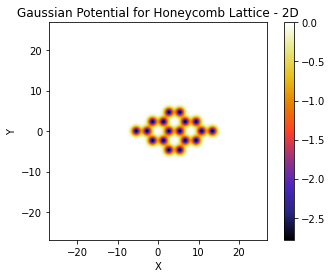

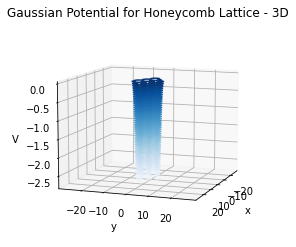

In [14]:
plt.figure()
plt.title('Gaussian Potential for Honeycomb Lattice - 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(V,extent=(l,r,l,r),cmap='CMRmap',origin='lower')
plt.colorbar()

# 3D Plot 
fig = plt.figure()
ax = plt.axes(projection='3d') # 3D plot
ax.contour3D(x, y, V, 50, cmap='Blues')
ax.view_init(10,20)
plt.title('Gaussian Potential for Honeycomb Lattice - 3D')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('V')
plt.show()

# Secant Hyperbolic Potential

In [15]:
# Tuning Parameters (Weak Pot)
V_a = 1.0
V= 0.0
for i in range(-1,2):
    for j in range(-1,2):
      r1 = (a1+a2)/3 +i*a1+j*a2
      r2 = 2*(a1+a2)/3+i*a1+j*a2
      V = V -V_a*(np.cosh(x-(r1[0]))**(-2)*np.cosh(y-(r1[1]))**(-2)+np.cosh(
                    x-(r2[0]))**(-2)*np.cosh(y-(r2[1]))**(-2))

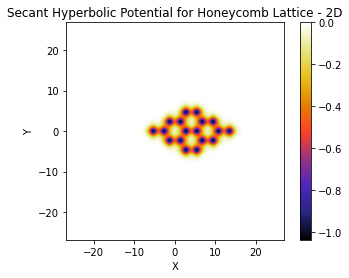

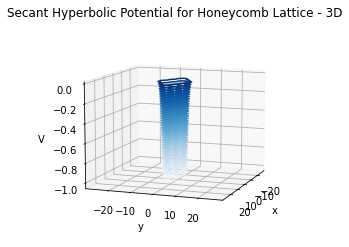

In [16]:
plt.figure()
plt.title('Secant Hyperbolic Potential for Honeycomb Lattice - 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(V,extent=(l,r,l,r),cmap='CMRmap',origin='lower')
plt.colorbar()

# 3D Plot 
fig = plt.figure()
ax = plt.axes(projection='3d') # 3D plot
ax.contour3D(x, y, V, 50, cmap='Blues')
ax.view_init(10,20)
plt.title('Secant Hyperbolic Potential for Honeycomb Lattice - 3D')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('V')
plt.show()

# Cosine Potential

In [17]:
# Potential 
V_a = 0.5263157894 #Best Cosine
V_b = 0.631578947
V = V_a*(np.cos(x*b1[0]+y*b1[1])+np.cos(x*b2[0]+y*b2[1])+ np.cos(
    x*(b1[0]+b2[0])+y*(b1[1]+b2[1])))+V_b*(np.cos(2*(x*b1[0]+y*b1[1]))+np.cos(
        2*(x*b2[0]+y*b2[1]))+ np.cos(2*(x*(b1[0]+b2[0])+y*(b1[1]+b2[1])))) 

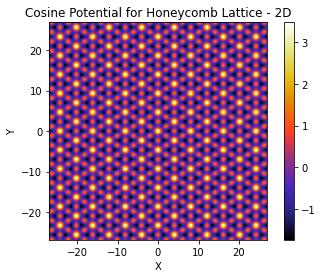

In [18]:
plt.figure()
plt.title('Cosine Potential for Honeycomb Lattice - 2D')
plt.xlabel('X')
plt.ylabel('Y')
plt.imshow(V,extent=(l,r,l,r),cmap='CMRmap',origin='lower')
plt.colorbar()

# Reciprocal Space

In [19]:
idx_g = 100 # Range for indices m,n for G = m*b1 + n*b2
ndim = 2 # Parameter for initialization of 2D list
G_cut = 4.9 # Euclidean distance cutoff from centre in reciprocal space
G = [[0 for k in range(ndim)] for j in range(0)]

for m in range(-idx_g,idx_g): # Looping through indices 
    for n in range(-idx_g,idx_g): 
        g = m*b1 + n*b2 # Reciprocal vector 
        if(np.linalg.norm(g)<=G_cut): # Condition for cutoff 
            # print(m,n)
            G.append(g) # Append to the list 
            
# Remove the initialized values and retain the appended  
# G.pop(0) 
G = np.array(G) # Making the list a numpy array 
Nb = len(G)
print(f"Number of Reciprocal lattice vector: {Nb}")

Number of Reciprocal lattice vector: 37


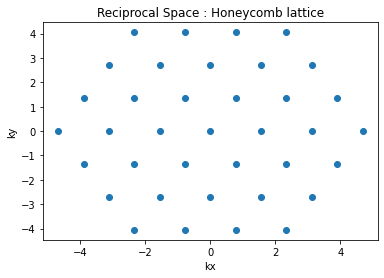

In [20]:
#Plotting Reciprocal lattice vectors 

plt.figure()
plt.title('Reciprocal Space : Honeycomb lattice')
plt.xlabel('kx')
plt.ylabel('ky')
plt.scatter(G[:,0], G[:,1]) 
plt.show()

# First Brillouin Zone

 A way to construct a Brillouin Zone (BZ) is by taking $\mathbf{k}$ = $\frac{m}{L}\mathbf{b_{2}}$ + $\frac{n}{L}\mathbf{b_{1}}$, where m and n are integers that run from 0 to L-1. The value of L controls the refinement of the BZ. Large the value of L, mrore are the number of points in the BZ.

In [21]:
# First Brillouin zone
 
K2 = [[0 for k in range(ndim)] for j in range(0)] # Initializing a 2D list
L = 50 # A grid of 2500 (50*50) points 
          
for m in range(0,L): 
    for n in range(0,L): 
        K2.append(float(m)/float(L)*b1 + float(n)/float(L)*b2)
             
K2 = np.array(K2) # Making the list a numpy array 

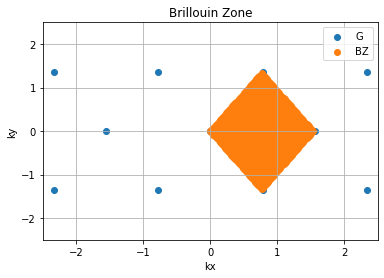

In [22]:
plt.figure()
plt.title('Brillouin Zone')
plt.xlabel('kx')
plt.ylabel('ky')
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.grid()
plt.scatter(G[:,0], G[:,1], label = 'G')
plt.scatter(K2[:,0], K2[:,1], label = 'BZ')
plt.legend()
plt.show()

We can recover the first BZ (or Weigner Seitz cell) for the honeycomb lattice by finding the nearest reciprocal wave vector to each point in the above BZ and shifting it by that vector. 

In [23]:
# Initializing a 2D list containing neighbouring G's
G_nbr = [[0 for k in range(ndim)] for j in range(0)] 

for i in range(0,len(G)): # Looping through all the recirprocal wave vectors G
    if(np.linalg.norm(G[i,:])<=2.0): # Finding vectors which are lesser or equal to 2 units from the centre.
        G_nbr.append(G[i,:]) # Appending to the list
        
G_nbr = np.array(G_nbr) # Making a numpy array

dist = np.zeros(len(G_nbr)) # Initializing an array to store the distance of a wave vector from neighbouring G's

for i in range(0,len(K2)): # Looping through wave vectors in off centered BZ
    for j in range(0,len(G_nbr)): # Looping through neighbouring G's
        dist[j] = np.linalg.norm(K2[i,:]-G_nbr[j,:]) # Stroring the distance from each neigbouring G
    K2[i,:] = K2[i,:]- G_nbr[np.argmin(dist),:] # Shifting the wave vector by the closest neighbour
        

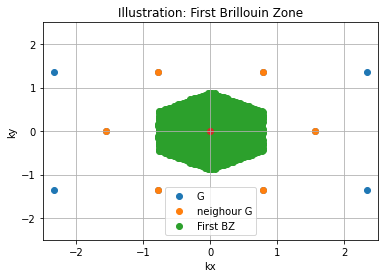

In [24]:
# Plotting first B.Z

plt.figure()
plt.title('Illustration: First Brillouin Zone')
plt.xlabel('kx')
plt.ylabel('ky')
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.grid()
plt.scatter(G[:,0], G[:,1], label = 'G')
plt.scatter(G_nbr[:,0], G_nbr[:,1], label = 'neighour G') 
plt.scatter(K2[:,0], K2[:,1], label = 'First BZ')
plt.legend()
plt.scatter(0, 0)
plt.show()

# 1d-Conventional Path

In [25]:
# Initializing three lists k1, k2 and k3 to stire the 1D symmetry path
k1 = [[0 for k in range(ndim)] for j in range(0)] 
k2 = [[0 for k in range(ndim)] for j in range(0)]
k3 = [[0 for k in range(ndim)] for j in range(0)]

Ky = np.linspace(0,4*np.pi/(3*np.sqrt(3)*a), 40) # y component of points from gamma to k
Kx = np.zeros(len(Ky)) # x component of points from gamma to k
Mx = np.linspace(0,np.pi/(3*a),40) # x component of points from k to m
My = np.linspace(4*np.pi/(3*np.sqrt(3)*a),np.pi/(np.sqrt(3)*a),40) # y component of points from k to m
Gamx = np.linspace(np.pi/(3*a),0,40) # x component of points from m to gamma
Gamy = np.linspace(np.pi/(np.sqrt(3)*a),0,40) # y component of points from m to gamma
for i in range (0,len(Ky)): # Looping through points
# Appending the lists with x and y components
   k1.append([Kx[i],Ky[i]])
   k2.append([Mx[i],My[i]])
   k3.append([Gamx[i],Gamy[i]])
    
# Removing the repeated points 
k2.pop(0)
k3.pop(0)

# Making numpy arrays 
k1 = np.array(k1)
k2 = np.array(k2)
k3 = np.array(k3)

# Concatenating all sub arrays to 1 single array such that they form a 1D path 
k_bnd = np.concatenate((k1,k2,k3))
# Stroing the indices of the gamma, k and m points
gampt = 0 
kpt  = len(k1)-1
mpt = kpt+len(k2)

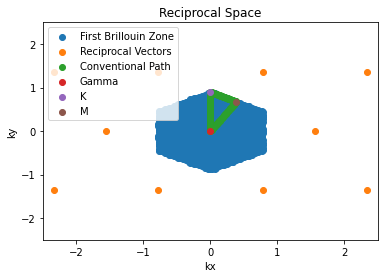

In [26]:
plt.figure()
plt.title('Reciprocal Space')
plt.xlabel('kx')
plt.ylabel('ky')
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.scatter(K2[:,0], K2[:,1], label = 'First Brillouin Zone') 
plt.scatter(G[:,0], G[:,1], label = 'Reciprocal Vectors')
plt.scatter(k_bnd[:,0], k_bnd[:,1], label = 'Conventional Path') 
plt.scatter(k_bnd[gampt,0], k_bnd[gampt,1],label = 'Gamma')
plt.scatter(k_bnd[kpt,0], k_bnd[kpt,1],label = 'K') 
plt.scatter(k_bnd[mpt,0], k_bnd[mpt,1],label = 'M') 
plt.legend()
plt.show()

# Tight Binding Band Structure

The idea is to calculate band structure resulting from three different potentials as mentioned above and find the closest fit of the first two bands to the tight binding band structure of graphene. The tight binding dispersion relationship of the graphene is given as,
$$
\begin{gather}
f(\mathbf{k}) = 2\hspace{2pt}cos(\sqrt{3}k_{y}a) + 4\hspace{2pt}cos(\frac{\sqrt{3}}{2}k_{y}a)\hspace{2pt}cos(\frac{3}{2}k_{x}a) \\
E_{\pm}(\mathbf{k}) = \pm t\sqrt{3+f(\mathbf{k})}-t'f(\mathbf{k})
\end{gather}
$$
where t is the nearest-neighbour hopping energy equal to 2.8 eV and t' is the next nearest-neighbour hopping energy equal to 0.1 eV (found out experimentally).

In [27]:
f = 2*np.cos(np.sqrt(3)*k_bnd[:,1]*a)+4*np.cos(
    np.sqrt(3)/2*k_bnd[:,1]*a)*np.cos(3/2*k_bnd[:,0]*a)
t = 2.8
t_ = 0.1
A = -t*np.sqrt(3+f)-t_*f
B=   t*np.sqrt(3+f)-t_*f

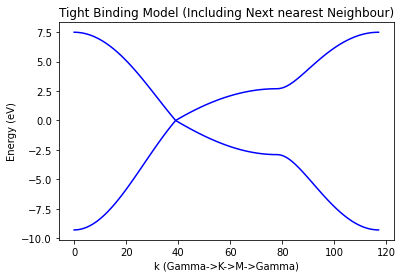

In [44]:
plt.figure()
plt.title('Tight Binding Model (Including Next nearest Neighbour)')
plt.ylabel ('Energy (eV)')
plt.xlabel('k (Gamma->K->M->Gamma)')
plt.plot(range(0,len(k_bnd)),A-np.max(A), color = 'b')
plt.plot(range(0,len(k_bnd)),B-np.max(A), color = 'b')
plt.show()

In [ ]:

def Band_Fit(param): # Potential tuning parameters
    if(len(param)==2): # Gaussian and Cosine Potential
        Z = {} # Initializing dictionary
        Va, Vb = param # Unpacking parameters
        for i in range (0, len(Va)): # Looping through first parameter
            V_a = Va[i] # Assigning each value
            for j in range(0, len(Vb)): # Looping through second parameter
                V_b = Vb[j] # Assigning each value 
                key = str(V_a)+" "+str(V_b) # Creating a key
                if(not key in Z): # if the key is not in dictionary 
                    psi,Ek = Band_Structure2D(k_bnd,G,V_a,V_b) # Calculating Band Structure 
                    Band_1 = (Ek[0,:]-np.max(Ek[0,:]))*27.21132 # Zero referencing the enery and converting to eV
                    Band_2 = (Ek[1,:]-np.max(Ek[0,:]))*27.21132
                    # Calculating Mean Square error (MSE)
                    p= np.square(np.subtract(Band_1,A-np.max(A))).mean() # Calculating Mean Square error
                    q = np.square(np.subtract(Band_2,B-np.max(A))).mean()
                    Z[key]= str(p)+","+str(q) # Storing the MSE as a string value 
        return Z # returning dictionary
    
        else: # Secant Hyperbolic Potential
            for i in range(0,len(Va)):
                Z = {}
                Va = param
                V_a = Va[i]
                key = str(V_a)
                if(not key in Z):
                    psi,Ek = Band_Structure2D(k_bnd,G,V_a,V_b)
                    Band_1 = (Ek[0,:]-Ek[0,kpt])*27.21132
                    Band_2 = (Ek[1,:]-Ek[0,kpt])*27.21132
                    p= np.square(np.subtract(Band_1,A-np.max(A))).mean()
                    q = np.square(np.subtract(Band_2,B-np.max(A))).mean()
                    Z[key]= str(p)+","+str(q)
            return Z
                    


In [ ]:
# Fit for Cosine
Va = np.linspace(0,2,20)
Vb = np.linspace(0,2,20)
z1 = Band_Fit([Va,Vb])
np.save('Cosine_fit.npy',z1) # save to binary files

# Fit for Gaussian 
Va = np.linspace(0,2,20)
Vb = np.linspace(0,2,20)
z2 = Band_Fit([Va,Vb])
np.save('Gaussian_fit.npy',z2)

# Fit for Sech
Va = np.linspace(0,6,100)
z3 = Band_Fit([Va])
np.save('Sech_fit.npy',z3)

In [19]:
Z1 = np.load('Cosine_fit.npy', allow_pickle = 'True').item()
Z2 = np.load('Sech_fit.npy', allow_pickle = 'True').item()
Z3 = np.load('Gaussian_fit.npy', allow_pickle = 'True').item()

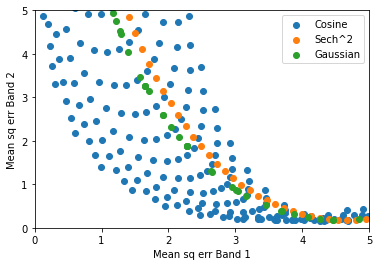

In [20]:
W1 = list(Z1.values())
W2 = list(Z2.values())
W3 = list(Z3.values())
W1 = np.array(W1)
W2 = np.array(W2)
W3 = np.array(W3)
X1 = np.zeros((len(W1),2))
X2 = np.zeros((len(W2),2))
X3 = np.zeros((len(W3),2))
for i in range(0,len(W1)):
    X1[i,:] = W1[i].split(',')
for i in range(0,len(W2)):
    X2[i,:] = W2[i].split(',')
for i in range(0,len(W3)):
    X3[i,:] = W3[i].split(',')
plt.figure()
plt.scatter(X1[:,0],X1[:,1],label='Cosine')
plt.scatter(X2[:,0],X2[:,1],label = 'Sech^2')
plt.scatter(X3[:,0],X3[:,1],label = 'Gaussian')
plt.ylabel('Mean sq err Band 2')
plt.xlabel('Mean sq err Band 1')
plt.legend()
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

It is found out that there does not exist a good fit for the tight binding model (including next nearest neighbour interactions) for the potentials above. So the same calculations are repeated for the tight bindng model including nearest neighbour interactions i.e setting t' = 0. 

In [28]:
t = 2.8
t_ = 0
A = -t*np.sqrt(3+f)-t_*f
B=   t*np.sqrt(3+f)-t_*f

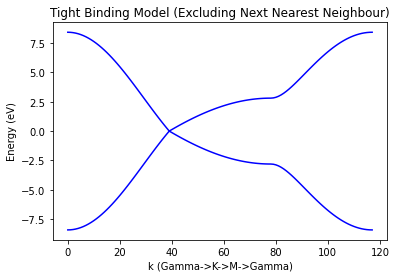

In [46]:
plt.figure()
plt.title('Tight Binding Model (Excluding Next Nearest Neighbour)')
plt.ylabel ('Energy (eV)')
plt.xlabel('k (Gamma->K->M->Gamma)')
plt.plot(range(0,len(k_bnd)),A-np.max(A), color = 'b')
plt.plot(range(0,len(k_bnd)),B-np.max(A), color = 'b')
plt.show()

Same as above, binary files are saved and mean square error is plotted.

In [41]:
Z1 = np.load('Cosine_fit(1).npy', allow_pickle = 'True').item()
Z2 = np.load('Gaussian_fit(1).npy', allow_pickle = 'True').item()
Z3 = np.load('Sech_fit(1).npy', allow_pickle = 'True').item()

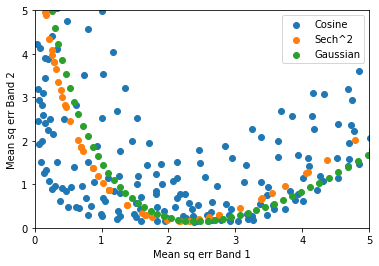

In [42]:
W1 = list(Z1.values())
W2 = list(Z2.values())
W3 = list(Z3.values())
W1 = np.array(W1)
W2 = np.array(W2)
W3 = np.array(W3)
X1 = np.zeros((len(W1),2))
X2 = np.zeros((len(W2),2))
X3 = np.zeros((len(W3),2))
for i in range(0,len(W1)):
    X1[i,:] = W1[i].split(',')
for i in range(0,len(W2)):
    X2[i,:] = W2[i].split(',')
for i in range(0,len(W3)):
    X3[i,:] = W3[i].split(',')
plt.figure()
plt.scatter(X1[:,0],X1[:,1],label='Cosine')
plt.scatter(X2[:,0],X2[:,1],label = 'Sech^2')
plt.scatter(X3[:,0],X3[:,1],label = 'Gaussian')
plt.ylabel('Mean sq err Band 2')
plt.xlabel('Mean sq err Band 1')
plt.legend()
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

It is found out that the $\mathbf{Cosine}$ function gives the best with $\mathbf{V_a}$ = $\mathbf{0.526}$ and $\mathbf{V_b}$ = $\mathbf{0.632}$ with mean square error in band 1 and band 2 equal to $\mathbf{0.77}$ and $\mathbf{0.69}$, respectively.

In [29]:
kbound=  k_bnd
V_a = 0.5263157894 # Best Cosine fit
V_b = 0.6315789473
tic  = timeit.default_timer()
psi,Ek = Band_Structure2D(kbound,G,V_a,V_b)
toc = timeit.default_timer()
print(f"Time taken for band structure calculation: {np.round(toc-tic,2)} seconds") 

Time taken for band structure calculation: 9.99 seconds


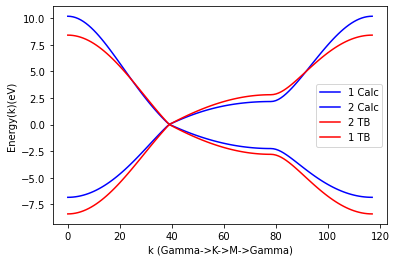

In [30]:
plt.figure()
for i in range(0,2): # First two bands
    plt.plot(range(0,len(kbound)),(Ek[i,:]-np.max(Ek[0,:]))*27.21132, label = str(i+1)+' Calc', color='b')
plt.plot(range(0,len(kbound)),A-np.max(A),label = '2 TB', color = 'r')
plt.plot(range(0,len(kbound)),B-np.max(A), label = '1 TB',color = 'r')
plt.xlabel('k (Gamma->K->M->Gamma)')
plt.ylabel('Energy(k)(eV)')
plt.legend()
plt.show()  

In [31]:
Band_1 = (Ek[0,:]-np.max(Ek[0,:]))*27.21132 # Zero referencing the enery and converting to eV
Band_2 = (Ek[1,:]-np.max(Ek[0,:]))*27.21132 
# Calculating Mean Square error (MSE)
p= np.square(np.subtract(Band_1,A-np.max(A))).mean() # Calculating Mean Square error
q = np.square(np.subtract(Band_2,B-np.max(A))).mean()
print(f"MSE in Band 1 = {np.round(p,2)} and MSE in Band 2 = {np.round(q,2)}")

MSE in Band 1 = 0.77 and MSE in Band 2 = 0.69


For all the further calculations, we will use Cosine potential with above stated tuning parameter values.

# Calculating Momentum Matrices

In [32]:
k0 = kpt - 5 # Near Dirac Cone (to get some high harmonics)
Enk0= Ek[:,k0] # Energy Dispersion at k0 value 

# Momentum matrix in x-direction
px = Momentum_Mat_2D(Nb,k0,G,0,psi,kbound) # Calculating Momentum Matrix 

# Diagonal and off-diagonal matrices 

# Diagonal matrix corresponds to intra-band current and off diagonal corresponds to inter-band current

pxd = px.diagonal() # Retrieving an array of diagonal elements
px_d = np.diag(pxd) # Constructing a matrix with just diagonal elements
px_nd = px-px_d # Constructing a matrix with non-diagonal diagonal elements

# Matrix in y-direction
py = Momentum_Mat_2D(Nb,k0,G,1,psi,kbound)

#Diagonal and off-diagonal matrices 

pyd = py.diagonal()
py_d = np.diag(pyd)
py_nd = py-py_d

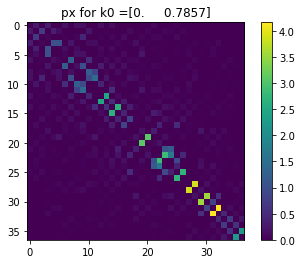

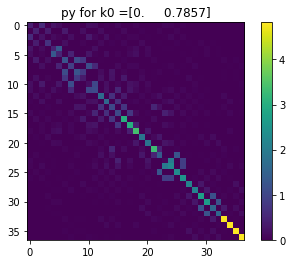

In [33]:
plt.figure()
plt.imshow(np.abs(px))
plt.colorbar()
plt.title('px for k0 =' +str(np.round(kbound[k0,:],4)))   
plt.show()
plt.figure()
plt.imshow(np.abs(py))
plt.title('py for k0 =' +str(np.round(kbound[k0,:],4)))      
plt.colorbar()
plt.show()

# Setup - Vector Potential

The idea is to use field parameter from a science paper by Yoshikawa N., Tamaya T. and Tanaka K (2017). The peak intensity of the pump pulse is 1.7 TW/${cm}^{2}$ which correspons to a electric field amplitude of 35.77 MV/cm. The energy of the pulse is 0.26 eV or the centra wavelength is 4.78 $\mu$ m. The paper states the result for linearly plolarized, circular polarized and elliptical polarized ($\epsilon$ = 0.32) field. Moreover, the spectrum of excitation pulse has a full width at half maximum (FWHM) of 60 meV.  

In [34]:
wenv=0.37*3.5194e13 # Frequency envelope (controls FWHM)
c = 3e8 # Speed of light 
eps = 8.854e-12 # Electrical permittivity 
E0=np.sqrt(2*1.7e16/(c*eps)) # Calculating Electric field from Intensity
tini = -np.pi/(2*wenv) #Initial time
tend = np.pi/(2*wenv)  #End time

dt = 0.27*(2.418e-17) #time spacing in s
t = np.arange(tini,tend,dt) # time array
E = E0*np.cos(wenv*t)**4 # Field Envelope
I = c*eps*E**2/2 # Intensity

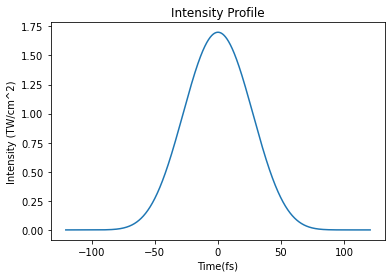

In [78]:
plt.figure()
plt.plot(t*1e15,I*1e-16)
plt.xlabel('Time(fs)')
plt.title('Intensity Profile')
plt.ylabel('Intensity (TW/cm^2)')
plt.show()

In [82]:
# Fourier Transform of the Intensity (to check  if FWHM == 60 meV)
Iw = (np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))) 
Nt = len(t)
dw=(2*np.pi)/(Nt*dt) # Frequency Spacing 
W = np.arange(-(Nt-1)*dw/2,Nt*dw/2,dw) # Array of frequencies 

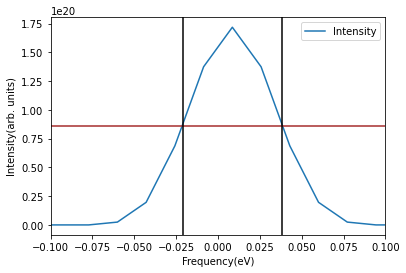

In [83]:
plt.figure()
plt.plot(sc.hbar*W/(1.6e-19),np.abs(Iw),label='Intensity')
plt.xlim(-0.1,0.1)
plt.axhline(y = np.max(np.abs(Iw))/2.0,color = 'brown')
plt.axvline(x=-0.021,color = 'black')
plt.axvline(x=0.038,color = 'black')
plt.xlabel('Frequency(eV)')
plt.ylabel('Intensity(arb. units)')
plt.legend()
plt.show()

In [86]:
l,r = half_max_x(sc.hbar*W/(1.6e-19),np.real(Iw))
fwhm = r-l
print(f"The Full width at half max is {np.round(fwhm*1e3,2)} meV")

The Full width at half max is 60.08 meV


In [123]:
# Field Parameters in au
wenv = 0.37*3.5194e13*(2.418e-17) # Field envelope frequency
lmd= 6.626e-34*3e8/(0.26*1.6e-19) # Central Wavelength
c = 3e8 # Speed of light 
eps = 8.854e-12 # Electrical permittivity 
E0=np.sqrt(2*1.7e16/(c*eps)) # Calculating Electric field from Intensity
E0x = E0/(5.142*1e11) # Field Amplitude in atomic units
E0y = 0

w0=(2*np.pi*c/lmd)*(2.418e-17) # Central Frequency in au
# Time Duration for fields

tini = -np.pi/(2*wenv) #Initial time
tend = np.pi/(2*wenv)  #End time

dt = 0.27 # Time Spacing 
T = np.arange(tini,tend,dt) # Array of time evaluation points
Nt = len(T)

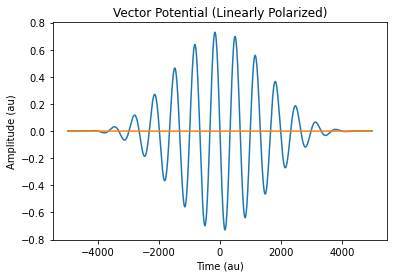

In [124]:
A_x = A_gen(tini, T,Ex,E0x) # generating array of vector potentialvalues
A_y = A_gen(tini, T,Ey,E0y) # generating array of vector potentialvalues
plt.figure()
plt.plot(T, [Ax(t,A_x) for t in T], label = 'Ax')
plt.plot(T, [Ay(t,A_y) for t in T], label = 'Ay')
plt.xlabel('Time (au)')
plt.ylabel('Amplitude (au)')
plt.title('Vector Potential (Linearly Polarized)')
plt.show()

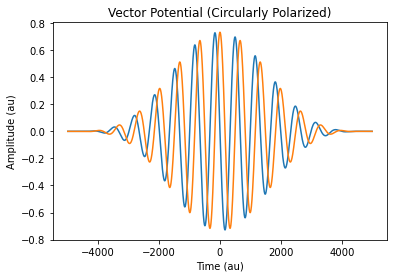

In [95]:
A_x = A_gen(tini, T,Ex,E0x) # generating array of vector potentialvalues
A_y = A_gen(tini, T,Ey,E0y) # generating array of vector potentialvalues
plt.figure()
plt.plot(T, [Ax(t,A_x) for t in T], label = 'Ax')
plt.plot(T, [Ay(t,A_y) for t in T], label = 'Ay')
plt.xlabel('Time (au)')
plt.ylabel('Amplitude (au)')
plt.title('Vector Potential (Circularly Polarized)')
plt.show()

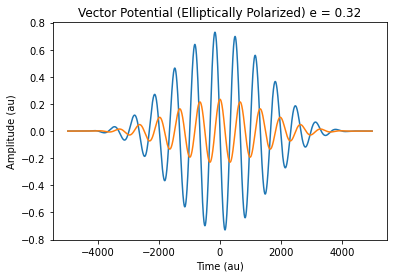

In [89]:
A_x = A_gen(tini, T,Ex,E0x) # generating array of vector potentialvalues
A_y = A_gen(tini, T,Ey,E0y) # generating array of vector potentialvalues
plt.figure()
plt.plot(T, [Ax(t,A_x) for t in T], label = 'Ax')
plt.plot(T, [Ay(t,A_y) for t in T], label = 'Ay')
plt.xlabel('Time (au)')
plt.ylabel('Amplitude (au)')
plt.title('Vector Potential (Elliptically Polarized) e = 0.32')
plt.show()

In [125]:
print("********************************************************")
print(f"\n****************Band Structure Parameters***************\n\nThe lattice spacing is {np.round(a,2)} au or {np.round(a*0.529177,2)} angstrom. The value of Va is {np.round(V_a,2)} and Vb is {np.round(V_b,2)}")
print(f"\nNumber of k points in first BZ = {len(K2)}, Number of Bands or Reciprocal lattice vectors = {len(G)} and Number of points in 1D path = {len(k_bnd)}.")
print(f"\n*********************Field Parameters*******************\n\nElectric Field Amplitude in x direction = {np.round(E0x,4)} au or {np.round(E0x*(5.142),3)} GV/cm.\nIt corresponds to a peak intensity of {np.round((E0x*5.142e11)**2*c*eps/(2*10**16),2)} TW/cm^{2}")
print(f"\nElectric Field Amplitude in y direction = {np.round(E0y,4)} au or {np.round(E0y*(5.142),3)} GV/cm.\nIt corresponds to a peak intensity of {np.round((E0y*5.142e11)**2*c*eps/(2*10**16),2)} TW/cm^{2}")
print(f"\nThe field envelope frequency = {np.round(wenv,5)} au or {wenv/2.418e-17/10**12} THz and central frequency = {np.round(w0,4)} au or {np.round(2*np.pi*c/lmd/10**12,2)} Thz. The corresponding wavelength = {np.round(lmd*1e6,2)} micro m.")
print(f"\nInitial time of pulse = {np.round(tini,2)} au or {np.round(tini*2.4188e-17*10**15,2)} fs.\nEnd time of pulse = {np.round(tend,2)} au or {np.round(tend*2.4188e-17*10**15,2)} fs.\nTime Spacing = {dt} au or {np.round(dt*2.418e-17*1e18,2)} as.\nNumber of time points = {Nt}")
print("\n********************************************************")

********************************************************

****************Band Structure Parameters***************

The lattice spacing is 2.68 au or 1.42 angstrom. The value of Va is 0.53 and Vb is 0.63

Number of k points in first BZ = 2500, Number of Bands or Reciprocal lattice vectors = 37 and Number of points in 1D path = 118.

*********************Field Parameters*******************

Electric Field Amplitude in x direction = 0.007 au or 0.036 GV/cm.
It corresponds to a peak intensity of 1.7 TW/cm^2

Electric Field Amplitude in y direction = 0 au or 0.0 GV/cm.
It corresponds to a peak intensity of 0.0 TW/cm^2

The field envelope frequency = 0.00031 au or 13.02178 THz and central frequency = 0.0095 au or 394.48 Thz. The corresponding wavelength = 4.78 micro m.

Initial time of pulse = -4988.77 au or -120.67 fs.
End time of pulse = 4988.77 au or 120.67 fs.
Time Spacing = 0.27 au or 6.53 as.
Number of time points = 36954

********************************************************


# Solving TDSE Numerically (Single Momentum Channel)

In [66]:
D = np.zeros(Nb, complex) # Interaction Picture Coefficients
D[0] = 1 # Initial Population in first band 


# Solved using built-in function evolve method (incompatible with numba) (slow)
# tic  = timeit.default_timer()
# T1,U1 = evolve(TDSE_Bloch_2D,tini,tend,dt, D, rk4) 
# toc = timeit.default_timer()
# print(f"Time taken for solving TDSE {np.round(toc-tic,2)} seconds")

# # Solved using built-in function special evolve method (compatible with numba) (slow)
tic  = timeit.default_timer()
T1,U1 = evolve_special(tini,tend,dt,D,px,py,k0,Nb,Ax,Ay,A_x,A_y) 
toc = timeit.default_timer()
print(f"Time taken for TDSE {np.round(toc-tic,2)} seconds")

Time taken for TDSE 0.84 seconds


# High Harmonic Spectrum (Single Momentum Channel)

In [67]:
tic  = timeit.default_timer() 
# Current in x-direction
jx = Current(T1, U1, px, Nb, k0, Ax,A_x) 
jx_intra = Current(T1, U1, px_d, Nb, k0, Ax, A_x) # Intra-Band Current
jx_inter =  Current(T1, U1, px_nd, Nb, k0, Ax, A_x) # Inter-Band Current

# Fourier Transform of Currents
wx, jwx = Current_Fourier(jx)
_, jwx_intra = Current_Fourier(jx_intra) 
_, jwx_inter  = Current_Fourier(jx_inter) 

# Current in y-direction
jy = Current(T1, U1, py, Nb, k0, Ay,A_y)
jy_intra = Current(T1, U1, py_d, Nb, k0, Ay,A_y)
jy_inter = Current(T1, U1, py_nd, Nb, k0, Ay,A_y)
wy, jwy = Current_Fourier(jy) 
# Fourier Transform of Currents
_, jwy_intra = Current_Fourier(jy_intra)
_, jwy_inter  = Current_Fourier(jy_inter) 
toc = timeit.default_timer()
print(f"Time taken for calculating current {np.round(toc-tic,2)} seconds")
spec_x = np.abs(jwx)**2 # High Harmonic Spectrum 
spec_x_intra = np.abs(jwx_intra)**2
spec_x_inter = np.abs(jwx_inter)**2
spec_y = np.abs(jwy)**2 # High Harmonic Spectrum 
spec_y_intra = np.abs(jwy_intra)**2
spec_y_inter = np.abs(jwy_inter)**2

Time taken for calculating current 0.6 seconds


In [68]:
spec_t = spec_x+spec_y # Total Spectrum
w = wx

No handles with labels found to put in legend.


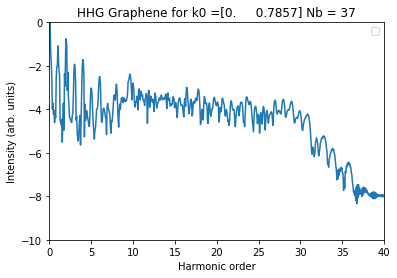

In [70]:
plt.figure()
plt.title('HHG Graphene for k0 =' +str(np.round(kbound[k0,:],4))+' Nb = '+str(Nb))
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Harmonic order')
plt.plot(w/w0,np.log10(np.abs(np.abs(spec_t/np.max(spec_t)))))
plt.legend()
plt.xlim(0,40)
plt.ylim(-10,0)
plt.show()

# Superposition of Momentum Channels

Here, I illustrate the calculationg of High Harmonic spectru for a sperposition of momentum channels. In this particular values I use k points in 1D Symmetry path for superposition. But the exact same procedure is used for k points in a BZ.

In [71]:
# Initializing Fourier transform of total current from different channels
jw_tx = np.zeros(Nt, dtype = np.complex128) 
jw_ty = np.zeros(Nt, dtype = np.complex128)

tic  = timeit.default_timer()
for idx in range(0,len(kbound)): # Looping over different k values (momentum channels)
    px = np.zeros((Nb,Nb),complex) # Initializing Momentum Matrix 
    py = np.zeros((Nb,Nb),complex) # Initializing Momentum Matrix 
    px = Momentum_Mat_2D(Nb,idx,G,0,psi,kbound) # Momentum Matrix for each k value 
    py = Momentum_Mat_2D(Nb,idx,G,1,psi,kbound)
    B = np.zeros(Nb, complex)
    B[0] = 1  # Inital condition (Population in valence band)
    T1,U1 = evolve_special(tini,tend,dt,B,px,py,idx,Nb,Ax,Ay,A_x,A_y)  
    jx = Current(T1, U1, px, Nb,idx,Ax,A_x)   
    jy = Current(T1, U1, py, Nb,idx,Ay,A_y)
    wx, jwx = Current_Fourier(jx)
    wy, jwy = Current_Fourier(jy)
    jw_tx = jw_tx +jwx # Adding up the individiual fft of currents (Superposition)
    jw_ty = jw_ty +jwy
toc = timeit.default_timer()
print(f"Time taken for calculating superposition: {np.round(toc-tic,2)} seconds")

Time taken for calculating superposition: 171.76 seconds


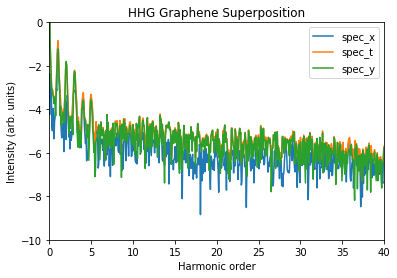

In [78]:
specx = np.abs(jw_tx)**2  # Calculating Spectrum 
specy = np.abs(jw_ty)**2
spect = specx + specy

plt.figure()
plt.title('HHG Graphene Superposition')
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Harmonic order')
plt.plot(wx/w0,np.log10(np.abs(np.abs(specx/np.max(spect)))), label = 'spec_x')
plt.plot(wx/w0,np.log10(np.abs(np.abs(spect/np.max(spect)))), label = 'spec_t')
plt.plot(wx/w0,np.log10(np.abs(np.abs(specy/np.max(spect)))), label = 'spec_y')
plt.legend()
plt.xlim(0, 40)
plt.ylim(-10,0)
plt.show()

# Variation of High Harmonic Intensity with each k-point.

Now I calculate the high harmonic yield for each k point (1D path) and plot it to visualize the variation.

In [96]:
I = np.zeros((Nt, len(kbound))) # Fourier transform of total current from different channels
tic  = timeit.default_timer()
for idx in range(0,len(kbound)): # Indices of different k values (dk = pi/20 a0)
    p_x = np.zeros((Nb,Nb),complex) # Initializing Momentum Matrix 
    p_y = np.zeros((Nb,Nb),complex) # Initializing Momentum Matrix 
    p_x = Momentum_Mat_2D(Nb,idx,G,0,psi,kbound) # Momentum Matrix for each k value 
    p_y = Momentum_Mat_2D(Nb,idx,G,1,psi,kbound)
    B = np.zeros(Nb, complex)
    B[0] = 1  # Inital condition (Population in valence band)
    T1,U1 = evolve_special(tini,tend,dt,B,p_x,p_y,idx,Nb,Ax,Ay,A_x,A_y)  
    jx = Current(T1, U1, p_x, Nb, idx,Ax,A_x) 
    wx, jwx = Current_Fourier(jx)
    spec_x = np.abs(jwx)**2
    jy = Current(T1, U1, p_y, Nb,idx,Ay,A_y)
    wy, jwy = Current_Fourier(jy)
    spec_y = np.abs(jwy)**2
    spec_t = spec_x + spec_y
    I[:,idx] = np.log10(np.abs(np.abs(spec_t/np.max(spec_t)))) # Storing HH Intensity for each k point in a matrix
toc = timeit.default_timer()
print(f"Time taken for calculation : {np.round(toc-tic,2)} seconds")   

Time taken for calculation : 186.02 seconds


# Plots for three types of polarizations mentioned above.

Linearly Polarized ($\epsilon$ = 0.0)

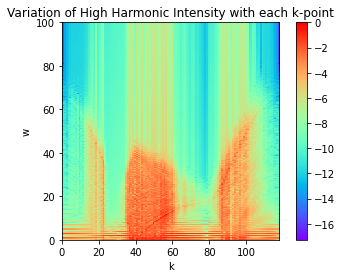

In [82]:
wlim = 100 # Max harmonic order to display in plot
plt.xlabel('k')
plt.ylabel('w')
plt.imshow(I,extent=(0, len(kbound), np.min(wx/w0),np.max(wx/w0)), cmap='rainbow',
            aspect = len(kbound)/wlim,interpolation= 'none', origin='lower')
plt.ylim(0,wlim)
plt.xlim(0,len(kbound))
plt.title('Variation of High Harmonic Intensity with each k-point')
plt.colorbar()

Elliptical Polarized ($\epsilon$ = 0.32)

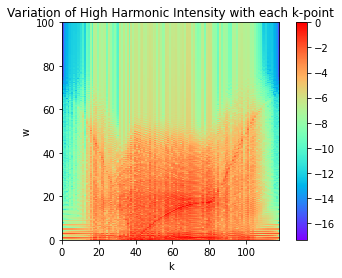

In [91]:
wlim = 100 # Max harmonic order to display in plot
plt.xlabel('k')
plt.ylabel('w')
plt.imshow(I,extent=(0, len(kbound), np.min(wx/w0),np.max(wx/w0)), cmap='rainbow',
            aspect = len(kbound)/wlim,interpolation= 'none', origin='lower')
plt.ylim(0,wlim)
plt.xlim(0,len(kbound))
plt.title('Variation of High Harmonic Intensity with each k-point')
plt.colorbar()

Circular Polarized ($\epsilon$ = 1.0)

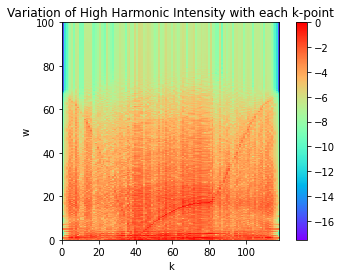

In [97]:
wlim = 100 # Max harmonic order to display in plot
plt.xlabel('k')
plt.ylabel('w')
plt.imshow(I,extent=(0, len(kbound), np.min(wx/w0),np.max(wx/w0)), cmap='rainbow',
            aspect = len(kbound)/wlim,interpolation= 'none', origin='lower')
plt.ylim(0,wlim)
plt.xlim(0,len(kbound))
plt.title('Variation of High Harmonic Intensity with each k-point')
plt.colorbar()

# Spot Size Integration

In the experiments, the intensity of the pump pulse is not constant as defined in the above simulation rather it varies as a function of position in 2D space. Therefore, here we consider the beam spot with a gaussian profile and find the average current $J_{avg}$ in each direction by integrating the current for each value of the electric field. Mathematically, this can be understood as,
$$
\begin{gather}
J_{avg} = \int d^{2}\mathbf{r}J(t, E_{0}e^{-\frac{|\mathbf{r}|^{2}}{2}}\mathbf{f}(t))\\
\end{gather}
$$
where,
$$
\begin{gather}
\mathbf{f}(t) = cos(\omega t) \mathbf{\hat{x}} + \epsilon sin(\omega t) \mathbf{\hat{y}}\\
|\mathbf{r}|^{2} = r_{x}^{2} +r_{y}^{2}
\end{gather}
$$
where $\epsilon$ is the ellipticity.

The integral can be converted into polar coordinates due to circular symmetry
$$
\begin{gather}
J_{avg}= \int_{0}^{2\pi}\int_{0}^{\infty}dr\hspace{1pt}rJ(t, E_{0}e^{-\frac{|\mathbf{r}|^{2}}{2}}\mathbf{f}(t))
\end{gather}
$$
Changing variables, E = $E_{0}e^{-\frac{|\mathbf{r}|^{2}}{2}}\mathbf{f}(t)$ and $\frac{dE}{E}$ = -rdr. When r = 0, the field has max amplitude $E_{0}$ and when r$\to$$\infty$, E $\to$0.

The integral now becomes
$$
\begin{gather}
J_{avg}= 2\pi\int_{0}^{E_{0}}dE\frac{J(t,E)}{E}
\end{gather}
$$
The integral does not diverge at E  $\to$ 0 as J = 0 for it.

In this simulation, we consider 40 electric field values from 0 to 35.77 MV/cm (or I = 1.7TW/$cm^{2}$). Then we find the current $\mathbf{J}$ vector for a superposition of k points (2500 points) in first BZ for each electric field value. then, using the trapezoidal rule, we integrate the current to find the avergae current $\mathbf{J_{avg}}$. Again, this process is repeated for three type of polarizations as mentioned above. We save current for each value of E to a binary file as a run for each polarization takes aout 8 hours. Finally, we extract the data from the files and analyze the results using the code below.

In [102]:
# Method for extracting current data from the files

def Current_Extract(pol, # Type of Polarization
                    Ne): # Number of Electric Field values
    jt_x = np.zeros((Ne,Nt), dtype = np.complex128) # Total current in x-diection
    
    jt_y = np.zeros((Ne,Nt), dtype = np.complex128) # total current in y-direction
   
    for i in range(0,Ne): # looping over field points
       # Loading the data from the files 
       jt_x[i,:] = np.load('curr_x_'+pol+str(np.round(E[i]*1e-3,4))+'.npy') 
       jt_y[i,:] = np.load('curr_y_'+pol+str(np.round(E[i]*1e-3,4))+'.npy')                
    return jt_x,jt_y

# Method to return HH intensity for each Electric field point
def Intensity(jx,jy,Ne):
    # Initializing HH intensity arrays
    I_x = np.zeros((Ne,Nt))
    I_y =  np.zeros((Ne,Nt))
    I_t  =  np.zeros((Ne,Nt))
    for i in range(0,Ne): # Looping over field points
        
        # Intensity in x-direction 
        wx,jw_x = Current_Fourier(jx[i,:])
        spect_x = np.abs(jw_x)**2
        # I_x[i,:] = np.log10(np.abs(np.abs(spect_x/np.max(spect_x))))
        I_x[i,:] = np.log10(np.abs(np.abs(spect_x)))
         # Intensity in y-direction     
        wy,jw_y = Current_Fourier(jy[i,:])
        spect_y = np.abs(jw_y)**2
        # I_y[i,:] = np.log10(np.abs(np.abs(spect_y/np.max(spect_y))))
        I_y[i,:] = np.log10(np.abs(np.abs(spect_y)))
        
         # Total Intensity 
        I_t[i,:] =  np.log10(np.abs(np.abs((spect_x+spect_y
                                        ))))
        # I_t[i,:] =  np.log10(np.abs(np.abs((spect_x+spect_y
        #                                 )/np.max(spect_x+spect_y))))
    return I_x, I_y, I_t

#  Spot Size integration using trapezoidal rule 

def Spot_Int(jx,jy,Ne,elp = 1):
   dE = E[1]-E[0] # Electric Field spacing
# Initializing the average current in x and y directions
   jtot_x = 0+0j 
   jtot_y = 0+0j
# trapezoidal Rule
   for i in range(1,Ne-1):
      jtot_x = jtot_x+ dE*jx[i,:]/E[i]
      jtot_y = jtot_y+ dE*jy[i,:]/(elp*E[i])
        
# The end point E = 0 is not includes as J = 0 for it
   jtot_x = jtot_x+ 0.5*dE*(jx[Ne-1,:]/E[Ne-1])
   jtot_y = jtot_y+ 0.5*dE*(jy[Ne-1,:]/(elp*E[Ne-1]))

   return jtot_x, jtot_y # return average currents 

In [103]:
E = np.linspace(0,35.77, 40) # electric field points
I = c*eps*(E)**2/2 # corresponding intensities

In [114]:
# Without Spot Size Integation

# Linear Polarization
jtx_lin = np.load('curr_x_lin0.0358.npy')
jty_lin = np.load('curr_y_lin0.0358.npy')
wx_lin,jwx_lin = Current_Fourier(jtx_lin)
wy_lin,jwy_lin = Current_Fourier(jty_lin)
specx_lin = wx_lin**2*np.abs(jwx_lin)**2
specy_lin = wy_lin**2*np.abs(jwy_lin)**2
spect_lin = specx_lin+specy_lin

# Circular polarization
jtx_circ = np.load('curr_x_circ0.0358.npy')
jty_circ = np.load('curr_y_circ0.0358.npy')
wx_circ, jwx_circ = Current_Fourier(jtx_circ)
wy_circ, jwy_circ = Current_Fourier(jty_circ)
specx_circ = wx_circ**2*np.abs(jwx_circ)**2 
specy_circ = wy_circ**2*np.abs(jwy_circ)**2
spect_circ = specx_circ+specy_circ

# Elliptial Polarization
jtx_elp = np.load('curr_x_elp0.0358.npy')
jty_elp = np.load('curr_y_elp0.0358.npy')
wx_elp, jwx_elp = Current_Fourier(jtx_elp)
wy_elp, jwy_elp = Current_Fourier(jty_elp)
specx_elp = wx_elp**2*np.abs(jwx_elp)**2 
specy_elp = wy_elp**2*np.abs(jwy_elp)**2
spect_elp = specx_elp+specy_elp

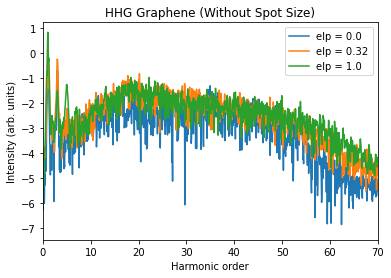

In [115]:
#%% Plotting the spectrum

plt.figure()
plt.title('HHG Graphene (Without Spot Size)')
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Harmonic order')
plt.plot(wx_lin/w0,np.log10(np.abs(np.abs(spect_lin/np.max(spect_lin)))), label = 'elp = 0.0')
plt.plot(wx_elp/w0,np.log10(np.abs(np.abs(spect_elp/np.max(spect_lin)))), label = 'elp = 0.32')
plt.plot(wx_circ/w0,np.log10(np.abs(np.abs(spect_circ/np.max(spect_lin)))), label = 'elp = 1.0')
plt.legend()
plt.xlim(0, 70)
plt.show()

In [116]:
# With Spot Integration

ne = len(E) # Number of field points to be integrated
# ne = len(E)-12
# ne = len(E)-30
print(f"Max E = {str(np.round(E[ne-1],2))} MV/cm\nMax I = {str(np.round(I[ne-1],2))} TW/cm^2")

jx_lin, jy_lin = Current_Extract('lin',ne) # Extracting Current Matrix
Ix_lin,Iy_lin, It_lin = Intensity(jx_lin,jy_lin,ne) # Calculating Intensity for each E
jtx_lin,jty_lin = Spot_Int(jx_lin,jy_lin,ne) # Spot size integration
wx, jwx_lin = Current_Fourier(jtx_lin) # fourier transform
wy, jwy_lin = Current_Fourier(jty_lin)
specx_lin = wx**2*np.abs(jwx_lin)**2  
specy_lin = wy**2*np.abs(jwy_lin)**2
spect_lin = specx_lin+specy_lin

jx_circ, jy_circ = Current_Extract('circ',ne)
Ix_circ,Iy_circ, It_circ = Intensity(jx_circ,jy_circ,ne)
jtx_circ,jty_circ = Spot_Int(jx_circ,jy_circ,ne)
wx, jwx_circ = Current_Fourier(jtx_circ)
wy, jwy_circ = Current_Fourier(jty_circ)
specx_circ = wx**2*np.abs(jwx_circ)**2  
specy_circ = wy**2*np.abs(jwy_circ)**2
spect_circ = specx_circ+specy_circ

jx_elp, jy_elp = Current_Extract('elp',ne)
Ix_elp,Iy_elp, It_elp = Intensity(jx_elp,jy_elp,ne)
jtx_elp,jty_elp = Spot_Int(jx_elp,jy_elp,ne,elp = 1)
wx, jwx_elp = Current_Fourier(jtx_elp)
wy, jwy_elp = Current_Fourier(jty_elp)
specx_elp = wx**2*np.abs(jwx_elp)**2 
specy_elp = wy**2*np.abs(jwy_elp)**2
spect_elp = specx_elp+specy_elp

Max E = 35.77 MV/cm
Max I = 1.7 TW/cm^2


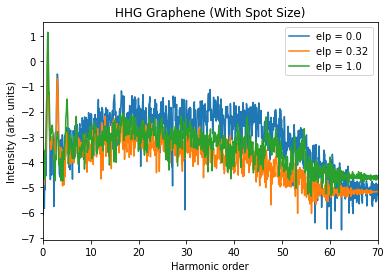

In [117]:
plt.figure()
plt.title('HHG Graphene (With Spot Size)')
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Harmonic order')
plt.plot(wx_lin/w0,np.log10(np.abs(np.abs(spec_t_lin/np.max(spect_lin)))), label = 'elp = 0.0')
plt.plot(wx_elp/w0,np.log10(np.abs(np.abs(spect_elp/np.max(spect_lin)))), label = 'elp = 0.32')
plt.plot(wx_circ/w0,np.log10(np.abs(np.abs(spect_circ/np.max(spect_lin)))), label = 'elp = 1.0')
plt.legend()
plt.xlim(0, 70)
plt.show()

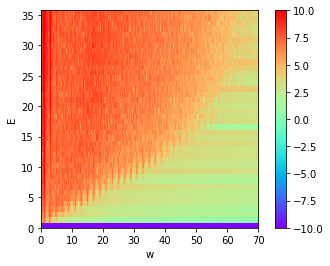

In [118]:
lim = 70
plt.xlabel('w')
plt.ylabel('E')
plt.title('Variation of HH Intensity as a function of E (Linear Polarization)')
l,r = It_lin.shape
plt.imshow(It_lin,extent = (np.min(wx/w0),np.max(wx/w0),np.min(E),np.max(E)), cmap='rainbow',
            aspect = lim/np.max(E),interpolation= 'none', origin='lower',vmin = -10, vmax = 10)
plt.ylim(np.min(E),np.max(E))
plt.xlim(0,lim)
plt.colorbar()     

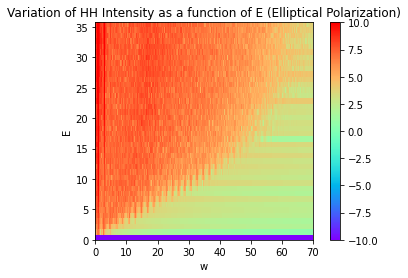

In [119]:
im = 70
plt.xlabel('w')
plt.ylabel('E')
plt.title('Variation of HH Intensity as a function of E (Elliptical Polarization)')
l,r = It_elp.shape
plt.imshow(It_elp,extent = (np.min(wx/w0),np.max(wx/w0),np.min(E),np.max(E)), cmap='rainbow',
            aspect = lim/np.max(E),interpolation= 'none', origin='lower',vmin = -10, vmax = 10)
plt.ylim(np.min(E),np.max(E))
plt.xlim(0,lim)
plt.colorbar()   

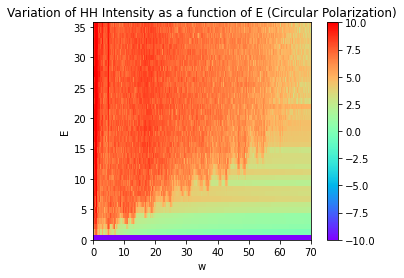

In [120]:
im = 70
plt.xlabel('w')
plt.ylabel('E')
plt.title('Variation of HH Intensity as a function of E (Circular Polarization)')
l,r = It_circ.shape
plt.imshow(It_circ,extent = (np.min(wx/w0),np.max(wx/w0),np.min(E),np.max(E)), cmap='rainbow',
            aspect = lim/np.max(E),interpolation= 'none', origin='lower',vmin = -10, vmax = 10)
plt.ylim(np.min(E),np.max(E))
plt.xlim(0,lim)
plt.colorbar()   